# Incorrect missing data prediction

In [1]:
# Preamble to run notebook in context of source package.
import sys
sys.path.insert(0, '../')

In [2]:
from IPython.core.display import display

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcdefaults()

from ptype.Ptype import Ptype
import pandas as pd
import numpy as np

### Rodents Dataset
This dataset is a collection of measurements about rodents in the Chihuahuan Desert near Portal, Arizona.

We consider the task of visualizing number of rodents of each species per year (note to myself: we could turn this into a forecasting problem).

Let us begin with reading the dataset for ptype with the usual configuration.

In [3]:
df = pd.read_csv('../data/rodents.csv', encoding="ISO-8859-1", dtype='str', keep_default_na=False)
df

,survey_id,recordID,mo,dy,yr,period,plot_id,plot,note1,stake,...,tag,note2,ltag,note3,prevrt,prevlet,nestdir,neststk,note4,note5
0,491ec41b-0a80-4ce9-b754-2983c6f38e71,6545,9,18,1982,62,4dc16022-f28d-4b9d-9062-c7bc3ad43362,13,13,36,...,,,,,,,,,,
1,f280bade-4e9b-447d-afe0-9e6d45e6bfb0,5220,1,24,1982,54,dcbbd373-c22e-46ef-ae8b-ad88f5cf7475,20,13,27,...,,,,,,,,,,
2,2b1b4a8a-c3e9-4781-a5f9-18b081383876,18932,8,7,1991,162,1e87b11b-4795-4f41-bdff-2d5c4412be25,19,13,33,...,,,,,,,,,,D
3,e98e66c4-514b-45f7-9d95-336c05a72b21,20588,1,24,1993,179,91829d58-c12e-47e8-ae31-185f46be21d2,12,13,41,...,,,,,,,,,,
4,768cdd0d-93bc-4c74-9dcd-d1ed48b7501e,7020,11,21,1982,63,f24f2db6-eadd-4de9-9d2f-95aea376c013,24,13,72,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35544,5e05640b-d193-482a-9e8d-10608f4e810b,35542,12,31,2002,295,6a090985-a7ce-4c04-b146-9b401d1dd796,15,,23,...,0F7659,,0,,0,0,,,,
35545,a6bbdcbb-2c0a-4d3f-85a0-62a73270a108,35543,12,31,2002,295,6a090985-a7ce-4c04-b146-9b401d1dd796,15,,77,...,701178,,0,,0,0,,,,
35546,67137ae7-0919-49c3-bd8f-4afda8162994,35544,12,31,2002,295,6a090985-a7ce-4c04-b146-9b401d1dd796,15,,64,...,,,,,,,,,,
35547,2bcb411b-9e81-42f6-a8db-aff0f863b564,35547,12,31,2002,295,c85de67c-1590-4129-8953-0c530a565585,10,,32,...,,,0,,0,0,,,UT,


In [4]:
df = df[['yr', 'species']]

Assume we use ptype to do a quick inspection of the data.

In [5]:
ptype = Ptype()
schema = ptype.schema_fit(df)
schema.show()

,yr,species
type,date-iso-8601,string
normal values,"[1977, 1978, 1979, 1980, 1981, 1982, 1983, 198...","[AB, AH, AS, BA, CB, CM, CQ, CS, CT, CU, CV, D..."
missing values,[],"[, NA]"
anomalous values,[],[]


In [6]:
# (As the number of columns is 38, it is difficult to inspect all the results 
# and notice that "NA" in the "species" column is misclassified. 
# Perhaps we could show the schema for columns with missing data only 
# so that it becomes obvious to the user.)
# to do: check if this can be easily noticed after filtering such columns
# ptype.cols['species']

With the help of ptype, we can notice that the species column contains missing data encoded by NA. However, "NA" is an abbreviation which stands for "Neotoma albigula" according to the meta-data. Therefore, we need to tell ptype to treat NA as a normal value, which can be done as follows:

In [7]:
na_values = ptype.machines.get_na_values()
print(na_values)

na_values.remove('NA')
ptype.machines.set_na_values(na_values)
print(ptype.machines.get_na_values())

# to-do: should we consider making this column specific rather than a global list
# this again can be done similar to how it is handled in pandas.read_csv which is 
# keep_default_na=False, na_values={'species':['']}

['NULL', 'null', 'Null', 'NA', 'NA ', ' NA', 'N A', 'N/A', 'N/ A', 'N /A', 'N/A', '#NA', '#N/A', 'na', ' na', 'na ', 'n a', 'n/a', 'N/O', 'NAN', 'NaN', 'nan', '-NaN', '-nan', '-', '!', '?', '*', '.', '-9999', '-99999', '', ' ']
['NULL', 'null', 'Null', 'NA ', ' NA', 'N A', 'N/A', 'N/ A', 'N /A', 'N/A', '#NA', '#N/A', 'na', ' na', 'na ', 'n a', 'n/a', 'N/O', 'NAN', 'NaN', 'nan', '-NaN', '-nan', '-', '!', '?', '*', '.', '-9999', '-99999', '', ' ']


In [8]:
schema = ptype.schema_fit(df)
schema.show()

,yr,species
type,date-iso-8601,string
normal values,"[1977, 1978, 1979, 1980, 1981, 1982, 1983, 198...","[AB, AH, AS, BA, CB, CM, CQ, CS, CT, CU, CV, D..."
missing values,[],[]
anomalous values,[],[]


We could then update our data frame where NA in the species column is treated as a normal value.

In [9]:
df = schema.transform(df)
df.head()

,yr,species
0,1982-01-01,AB
1,1982-01-01,AB
2,1991-01-01,AS
3,1993-01-01,AS
4,1982-01-01,AH


In [10]:
df['count'] = 1
df

,yr,species,count
0,1982-01-01,AB,1
1,1982-01-01,AB,1
2,1991-01-01,AS,1
3,1993-01-01,AS,1
4,1982-01-01,AH,1
...,...,...,...
35544,2002-01-01,PB,1
35545,2002-01-01,PB,1
35546,2002-01-01,US,1
35547,2002-01-01,RM,1


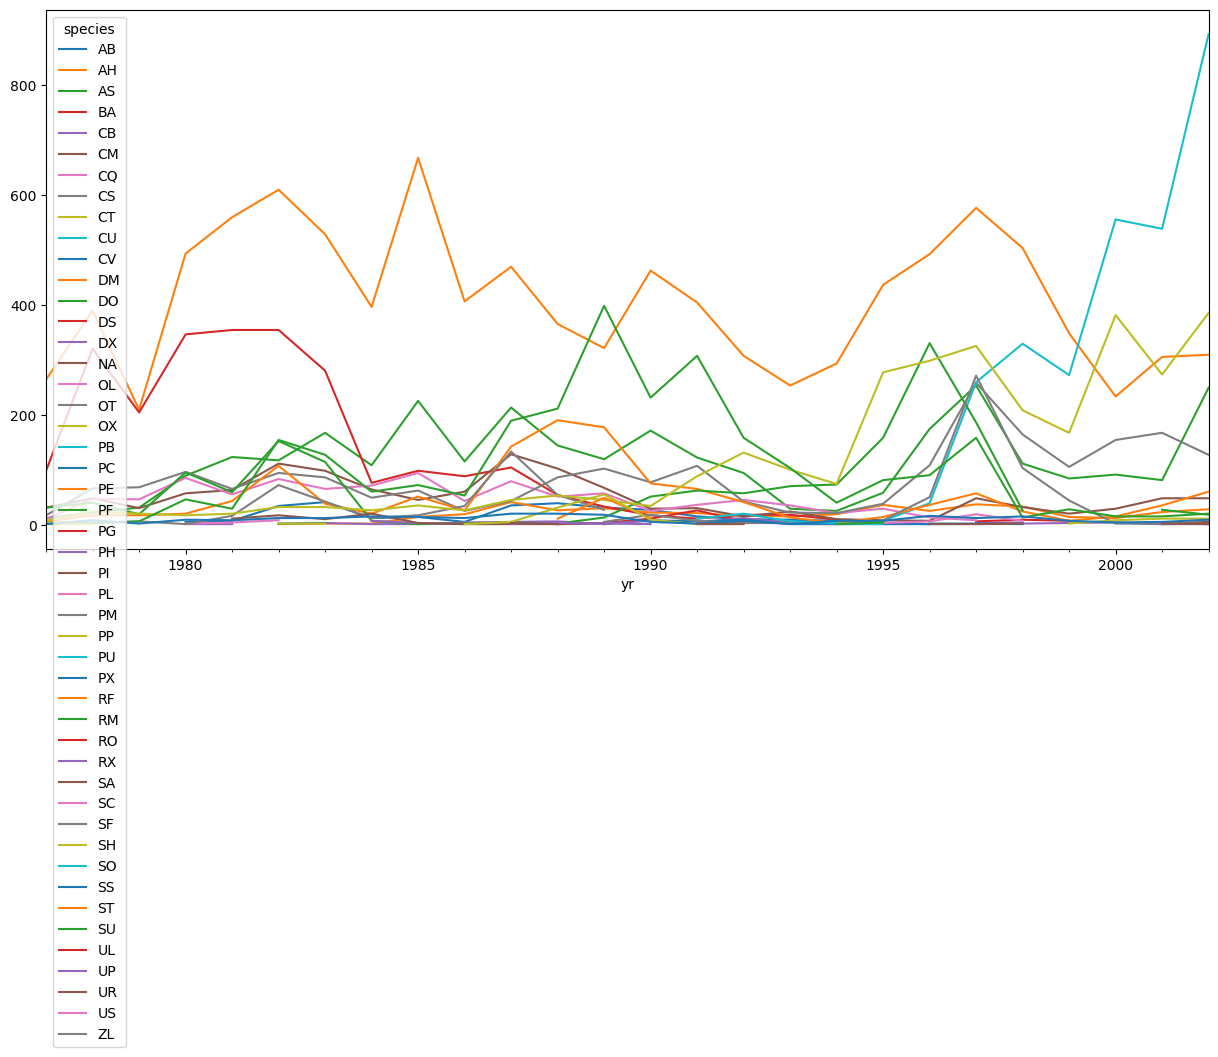

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
_ = df.groupby(['yr','species']).count()['count'].unstack().plot(ax=ax)